In [1]:
from spineq.optimise import get_optimisation_inputs
from spineq.utils import coverage_matrix
from spineq.plotting import plot_optimisation_result
from spineq.data_fetcher import get_oa_shapes, get_oa_centroids

import pygmo as pg

import numpy as np
import pandas as pd

from time import time

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
n_sensors = 20
theta = 500

population_weight = 1
workplace_weight = 1
pop_age_groups = {
    "pop_total": {"min": 0, "max": 90, "weight": 0},
    "pop_children": {"min": 0, "max": 16, "weight": 0},
    "pop_elderly": {"min": 70, "max": 90, "weight": 1},
}

## Get Input Data

In [3]:
data = get_optimisation_inputs(
    population_weight=population_weight,
    workplace_weight=workplace_weight,
    pop_age_groups=pop_age_groups,
    combine=False,
)

objs = list(data["oa_weight"].keys())
objs

['pop_elderly', 'workplace']

## PyGMO Multi-Objective Problem

- One decision variable for each sen?sor to be placed, variable value is index of location
- One objective per separate weight group defined above, e.g. total population, children, elderly and workplace.

In [4]:
# PyGMO User Defined Problem
class optimise_oa:
    def __init__(self, oa_x, oa_y, oa_weight,
                 n_sensors, theta):
        
        self.n_sensors = n_sensors
        self.n_locations = len(oa_x)
        self.n_obj = len(oa_weight)
        self.oa_weight = oa_weight
        self.coverage = coverage_matrix(oa_x, oa_y, theta=theta)
          
    def fitness(self, sensors_idx):
        """
        PyGMO required function.
        The objective function to minimise. And constraints to evaluate.
        """
        # Construct sensors vector from indices
        sensors = np.zeros(self.n_locations)
        sensors[sensors_idx.astype(int)] = 1
        
        fitness_sensors = []
        for w in self.oa_weight.values():
            # only keep coverages due to output areas where a sensor is present
            mask_cov = np.multiply(self.coverage, sensors[np.newaxis, :])

            # coverage at each output area = coverage due to nearest sensor
            max_mask_cov = np.max(mask_cov, axis=1)

            # weighted coverage of solution = the objective
            fitness_sensors.append(
                -(w * max_mask_cov).sum() / w.sum()
            )
        
        return fitness_sensors
    
    def get_bounds(self):
        """
        PyGMO required function.
        Defines min and max value for each parameter.
        """
        return ([0]*self.n_sensors, [self.n_locations-1]*self.n_sensors)
    
    # Return number of objectives
    def get_nobj(self):
        return self.n_obj
    
    def get_nec(self):
        """PyGMO function.
        Defines number of equality constraints."""
        return 0
    
    def get_nix(self):
        """
        PyGMO function.
        Number of integer dimensions.
        """
        return self.n_sensors
    
    def gradient(self, x):
        return pg.estimate_gradient_h(lambda x: self.fitness(x), x)
    


In [5]:
# Build problem
oa_opt = optimise_oa(
    data["oa_x"],
    data["oa_y"],
    data["oa_weight"],
    n_sensors,
    theta,
)

prob = pg.problem(oa_opt)

print(prob)

Problem name: <class '__main__.optimise_oa'>
	C++ class name: pybind11::object

	Global dimension:			20
	Integer dimension:			20
	Fitness dimension:			2
	Number of objectives:			2
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [0, 0, 0, 0, 0, ... ]
	Upper bounds: [951, 951, 951, 951, 951, ... ]
	Has batch fitness evaluation: false

	Has gradient: true
	User implemented gradient sparsity: false
	Expected gradients: 40
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0
	Gradient evaluations: 0

	Thread safety: none



## NSGA2

In [6]:
# Create algorithm to solve problem with
algo = pg.algorithm(uda = pg.nsga2(gen=1000))
algo.set_verbosity(1)
print(algo)

# population of problems
pop = pg.population(prob=prob, size=100)


Algorithm name: NSGA-II: [stochastic]
	C++ class name: pagmo::nsga2

	Thread safety: basic

Extra info:
	Generations: 1000
	Crossover probability: 0.95
	Distribution index for crossover: 10
	Mutation probability: 0.01
	Distribution index for mutation: 50
	Seed: 3843609999
	Verbosity: 1


f evals 100100
g evals 0


Text(0, 0.5, 'workplace')

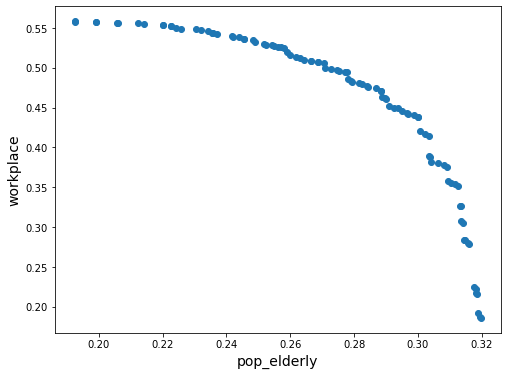

In [7]:
# solve problem
pop = algo.evolve(pop)

print("f evals", pop.problem.get_fevals())
print("g evals", pop.problem.get_gevals())

# extract results
fits, vectors = pop.get_f(), pop.get_x()
# extract non-dominated fronts
ndf, dl, dc, ndr = pg.fast_non_dominated_sorting(fits)

# plot fitness values for first two objectives
plt.figure(figsize=(8,6))
plt.plot(-fits[:,0], -fits[:,1], 'o')
plt.xlabel(objs[0], fontsize=14)
plt.ylabel(objs[1], fontsize=14)

In [8]:
# sort fits in order of first objective value
x = -fits.copy()
x[x[:, 0].argsort()]

array([[0.19249925, 0.55834652],
       [0.19253068, 0.55736084],
       [0.19920969, 0.55727066],
       [0.19920969, 0.55727066],
       [0.20569238, 0.55669663],
       [0.20590085, 0.55578185],
       [0.21240282, 0.55562077],
       [0.21403557, 0.55446186],
       [0.22020735, 0.55383989],
       [0.22020735, 0.55383989],
       [0.22250433, 0.55252439],
       [0.22250433, 0.55252439],
       [0.22408461, 0.55023205],
       [0.22571736, 0.54907314],
       [0.23046229, 0.54828037],
       [0.23191731, 0.54705832],
       [0.23421429, 0.54574282],
       [0.23532837, 0.5441807 ],
       [0.23579457, 0.54345048],
       [0.23718551, 0.54196522],
       [0.2417817 , 0.53956565],
       [0.24192345, 0.53861384],
       [0.2438575 , 0.53823616],
       [0.24543778, 0.53594382],
       [0.24543778, 0.53594382],
       [0.24842697, 0.53456793],
       [0.24889094, 0.53258157],
       [0.25187876, 0.52928747],
       [0.25251236, 0.52836155],
       [0.25416857, 0.52802859],
       [0.

## Other Algorithms

In [9]:
# Create algorithm to solve problem with
algo = pg.algorithm(uda = pg.moead(gen=100))
algo.set_verbosity(1)
print(algo)

# population of problems
pop = pg.population(prob=prob, size=105)


Algorithm name: MOEAD: MOEA/D - DE [stochastic]
	C++ class name: pagmo::moead

	Thread safety: basic

Extra info:
	Generations: 100
	Weight generation: grid
	Decomposition method: tchebycheff
	Neighbourhood size: 20
	Parameter CR: 1
	Parameter F: 0.5
	Distribution index: 20
	Chance for diversity preservation: 0.9
	Seed: 1120393477
	Verbosity: 1


f evals 10605
g evals 0


Text(0, 0.5, 'workplace')

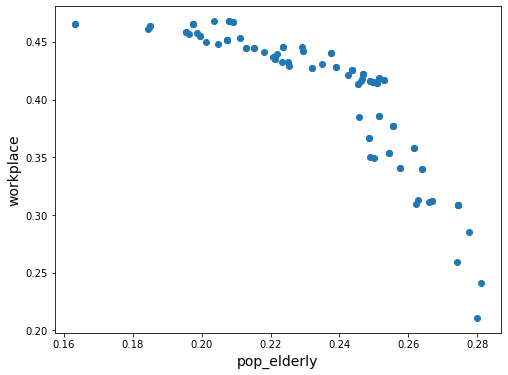

In [10]:
# solve problem
pop = algo.evolve(pop)

print("f evals", pop.problem.get_fevals())
print("g evals", pop.problem.get_gevals())

# extract results
fits, vectors = pop.get_f(), pop.get_x()
# extract non-dominated fronts
ndf, dl, dc, ndr = pg.fast_non_dominated_sorting(fits)

# plot fitness values for first two objectives
plt.figure(figsize=(8,6))
plt.plot(-fits[:,0], -fits[:,1], 'o')
plt.xlabel(objs[0], fontsize=14)
plt.ylabel(objs[1], fontsize=14)

## 3 Objectives?

In [11]:
population_weight = 1
workplace_weight = 1
pop_age_groups = {
    "pop_total": {"min": 0, "max": 90, "weight": 0},
    "pop_children": {"min": 0, "max": 16, "weight": 1},
    "pop_elderly": {"min": 70, "max": 90, "weight": 1},
}

data = get_optimisation_inputs(
    population_weight=population_weight,
    workplace_weight=workplace_weight,
    pop_age_groups=pop_age_groups,
    combine=False,
)


objs = list(data["oa_weight"].keys())
objs

['pop_children', 'pop_elderly', 'workplace']

In [12]:
# Build problem
oa_opt = optimise_oa(
    data["oa_x"],
    data["oa_y"],
    data["oa_weight"],
    n_sensors,
    theta,
)

prob = pg.problem(oa_opt)

print(prob)

Problem name: <class '__main__.optimise_oa'>
	C++ class name: pybind11::object

	Global dimension:			20
	Integer dimension:			20
	Fitness dimension:			3
	Number of objectives:			3
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [0, 0, 0, 0, 0, ... ]
	Upper bounds: [951, 951, 951, 951, 951, ... ]
	Has batch fitness evaluation: false

	Has gradient: true
	User implemented gradient sparsity: false
	Expected gradients: 60
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0
	Gradient evaluations: 0

	Thread safety: none



In [13]:
# Create algorithm to solve problem with
algo = pg.algorithm(uda = pg.nsga2(gen=1000))
algo.set_verbosity(1)
print(algo)

# population of problems
pop = pg.population(prob=prob, size=100)


Algorithm name: NSGA-II: [stochastic]
	C++ class name: pagmo::nsga2

	Thread safety: basic

Extra info:
	Generations: 1000
	Crossover probability: 0.95
	Distribution index for crossover: 10
	Mutation probability: 0.01
	Distribution index for mutation: 50
	Seed: 3732281879
	Verbosity: 1


In [14]:
# solve problem
pop = algo.evolve(pop)

print("f evals", pop.problem.get_fevals())
print("g evals", pop.problem.get_gevals())

# extract results
fits, vectors = pop.get_f(), pop.get_x()
# extract non-dominated fronts
ndf, dl, dc, ndr = pg.fast_non_dominated_sorting(fits)

print("Best fitness values for single objectives:")
for i in range(len(objs)):
    print(objs[i], fits[:,i].min())

f evals 100100
g evals 0
Best fitness values for single objectives:
pop_children -0.330662458048548
pop_elderly -0.317021211677647
workplace -0.5591696537860886


Text(0, 0.5, 'workplace')

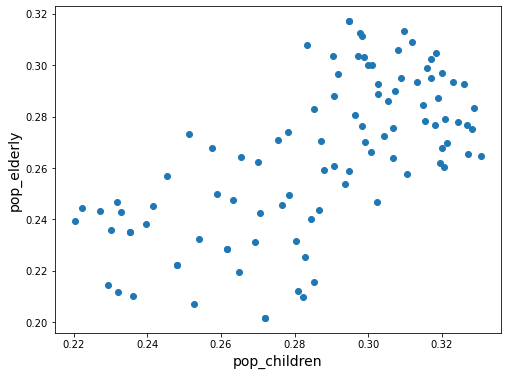

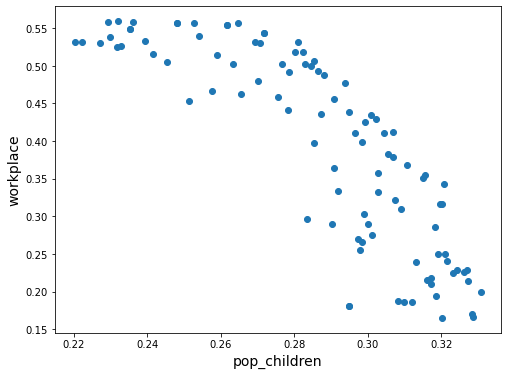

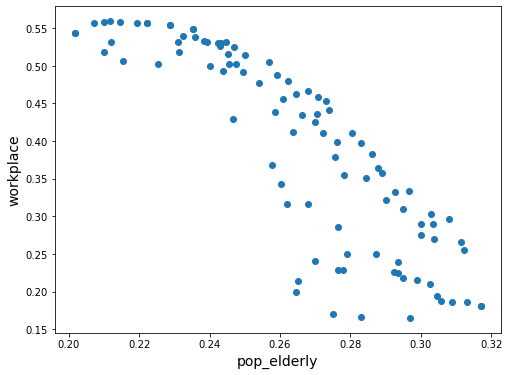

In [15]:
# plot fitness values for two objectives
objs = list(data["oa_weight"].keys())

plt.figure(figsize=(8,6))
plt.plot(-fits[:,0], -fits[:,1], 'o')
plt.xlabel(objs[0], fontsize=14)
plt.ylabel(objs[1], fontsize=14)

plt.figure(figsize=(8,6))
plt.plot(-fits[:,0], -fits[:,2], 'o')
plt.xlabel(objs[0], fontsize=14)
plt.ylabel(objs[2], fontsize=14)

plt.figure(figsize=(8,6))
plt.plot(-fits[:,1], -fits[:,2], 'o')
plt.xlabel(objs[1], fontsize=14)
plt.ylabel(objs[2], fontsize=14)

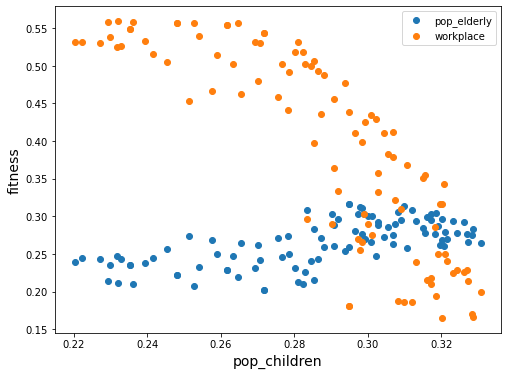

In [16]:
plt.figure(figsize=(8,6))
plt.plot(-fits[:,0], -fits[:,1], 'o', label=objs[1])
plt.plot(-fits[:,0], -fits[:,2], 'o', label=objs[2])
plt.xlabel(objs[0], fontsize=14)
plt.ylabel("fitness", fontsize=14)
plt.legend()

In [17]:
# sort fits in order of first objective value
x = -fits.copy()
x[x[:, 0].argsort()]

array([[0.22029356, 0.23931146, 0.532006  ],
       [0.2222768 , 0.244512  , 0.53104019],
       [0.2270165 , 0.24331116, 0.52989657],
       [0.22930967, 0.21450408, 0.55828962],
       [0.22995019, 0.2359406 , 0.53829345],
       [0.23181289, 0.24686811, 0.52545641],
       [0.23198076, 0.21166653, 0.55916965],
       [0.23293723, 0.24300924, 0.52632346],
       [0.23523211, 0.23513387, 0.54866938],
       [0.23523211, 0.23513387, 0.54866938],
       [0.23597808, 0.21007413, 0.55782665],
       [0.23948628, 0.2382967 , 0.53270967],
       [0.24148032, 0.24520776, 0.5152837 ],
       [0.24539966, 0.25682851, 0.50457673],
       [0.24813091, 0.22221296, 0.55732804],
       [0.24813091, 0.22221296, 0.55732804],
       [0.25139322, 0.27320231, 0.45297383],
       [0.25262011, 0.20722793, 0.55748743],
       [0.25409874, 0.2324114 , 0.54029669],
       [0.25766296, 0.26785215, 0.46708798],
       [0.25887997, 0.24996443, 0.51469649],
       [0.26153616, 0.22863   , 0.55367317],
       [0.